In [1]:
import pandas as pd
from pyprojroot import here
import numpy as np
from pathlib import Path

from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import kruskal, ranksums
import scikit_posthocs as sp

from nutils import interval_score, bootstrap, name_mask, pairwise

In [2]:
TARGET = 'occ'

In [3]:
true_matrix = pd.read_csv(
    here() / f'data/processed/true_matrices/{TARGET}.csv',
    index_col='datetime',
    parse_dates=True
)

In [4]:
def flatten(matrix):
    return matrix.values.flatten()

In [5]:
result_list = list()
error_list = list()
data_path = Path('data/processed/prediction_matrices/')

for p in here(data_path / '50').glob('*1.csv'):
    
    result = dict()
    
    parts = p.stem.split('-')
    
    result['Model'] = parts[1]
    result['FS'] = parts[2]
    name = parts[1] + '-' + parts[2]
    
    pred_matrix = pd.read_csv(
        p, 
        index_col='datetime', 
        parse_dates=True)
    
    idx = pred_matrix.dropna().index.intersection(true_matrix.dropna().index)

    pred_matrix = pred_matrix.loc[idx]
    true_matrix = true_matrix.loc[idx]
    
    true = true_matrix.groupby(true_matrix.index.month).apply(flatten).to_dict()
    pred = pred_matrix.groupby(pred_matrix.index.month).apply(flatten).to_dict()
    
    for month in range(1,13):
        rmse = mean_squared_error(true[month], pred[month])
        result[month] = rmse
        
    result_list.append(result)

In [6]:
df = pd.DataFrame(result_list)

df = df.round(0)
df.Model.replace(name_mask, inplace=True)
df.FS = df.FS.str.upper()

df['Mean'] = df.iloc[:,2:].mean(axis=1)
df = df.sort_values(by='Mean', ascending=False)
df = df.drop(columns='Mean')

In [7]:
df.iloc[:,2:] = df.iloc[:,2:].astype(int)

/tmp/ipykernel_24160/1518682526.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:,2:] = df.iloc[:,2:].astype(int)


In [8]:
df

,Model,FS,1,2,3,4,5,6,7,8,9,10,11,12
0,SN,U,153,193,177,124,149,165,145,164,147,162,126,197


In [9]:
df.median(numeric_only=True)

1     153.0
2     193.0
3     177.0
4     124.0
5     149.0
6     165.0
7     145.0
8     164.0
9     147.0
10    162.0
11    126.0
12    197.0
dtype: float64

In [ ]:
df.to_latex(
    buf = here() / 'output/tables/monthly_performance.tex',
    #float_format='%.0f',
    column_format='rp{5pt}p{5pt}p{5pt}p{5pt}p{5pt}p{5pt}p{5pt}p{5pt}p{5pt}p{5pt}p{5pt}p{5pt}p{5pt}',
    label='tab:monthly_performance',
    caption='Monthly performance of the tested models in RMSE.\
    FS = feature set',
    position='H',
    index=False,
    na_rep='-'
)

In [10]:
# Plot
df['Model'] = df['Model'] + '-' + df['FS']
df = df.drop(columns='FS')
df = df.set_index('Model')

<Axes: >

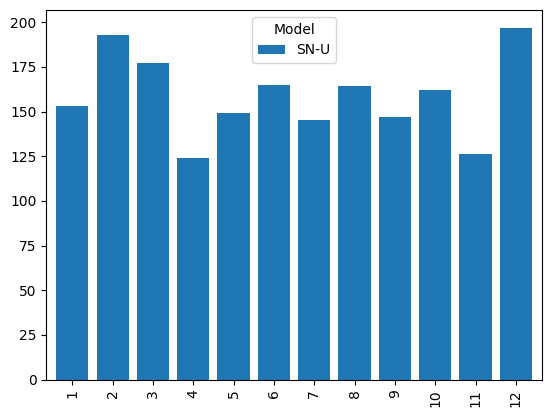

In [11]:
df.T.plot(kind='bar', width=.8)